# (10) Combine neural fits

**Motivation**: ...across different sim categories & analyze <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

## Path to move df files

In [3]:
path = pjoin(tmp_dir, 'results_combined')

## Save fit names to txt file

<span style="color:red">Warning! Run this only once</span>:

In [3]:
fits_local = sorted(os.listdir(results_dir()))

with open(pjoin(path, 'fits.txt'), 'a') as f:
    f.write(f"# computer name: {os.uname().nodename}\n")
    for item in fits_local:
        f.write(f"{item}\n")

## Copy fits to tmp dir

In [4]:
fits = []
with open(pjoin(path, 'fits.txt'), 'r') as f:
    for line in f:
        if '# computer name' in line:
            continue
        fits.append(line.split('\n')[0])

<span style="color:red">Warning! Run this only once</span>:

In [5]:
copy_fits(fits, path)

## Load & analyze

In [5]:
df = []
perf = {}
for fit_name in fits:
    if 'reservoir' in fit_name:
        continue
    _df = f"summary_{fit_name}.df"
    _df = pjoin(tmp_dir, 'results_combined', _df)
    _df = pd.read_pickle(_df)
    assert len(_df) == 141
    k = _df['category'].unique().item()
    if 'vanilla' in fit_name:
        k = f"vanilla-{k}"
        _df['category'] = k
    perf[k] = _df.perf.values
    df.append(_df)
df = pd.concat(df)

In [6]:
grouped_by_cat = collections.defaultdict(list)
grouped_by_nobj = collections.defaultdict(list)
for sim in sorted(df['category'].unique()):
    cat, n = sim[:-1], int(sim[-1])
    grouped_by_cat[cat].append(n)
    grouped_by_nobj[n].append(cat)
grouped_by_cat = dict(grouped_by_cat)
grouped_by_nobj = dict(grouped_by_nobj)

print(grouped_by_cat)
print(grouped_by_nobj)

{
    'fixate': [0, 1, 2, 4, 8],
    'obj': [1, 2, 4, 8],
    'terrain': [1, 2, 4, 8],
    'transl': [1, 2, 4, 8],
    'vanilla-fixate': [1]
}

{
    0: ['fixate'],
    1: ['fixate', 'obj', 'terrain', 'transl', 'vanilla-fixate'],
    2: ['fixate', 'obj', 'terrain', 'transl'],
    4: ['fixate', 'obj', 'terrain', 'transl'],
    8: ['fixate', 'obj', 'terrain', 'transl']
}

In [7]:
pal = {}
colors = ['Blues', 'Oranges', 'Greens', 'Purples', 'Greys']
for c, (k, v) in zip(colors, grouped_by_cat.items()):
    _pal = sns.color_palette(c, n_colors=len(v) + 3)[1:-2]
    for i in range(len(v)):
        pal[f"{k}{v[i]}"] = _pal[i]

## More plots

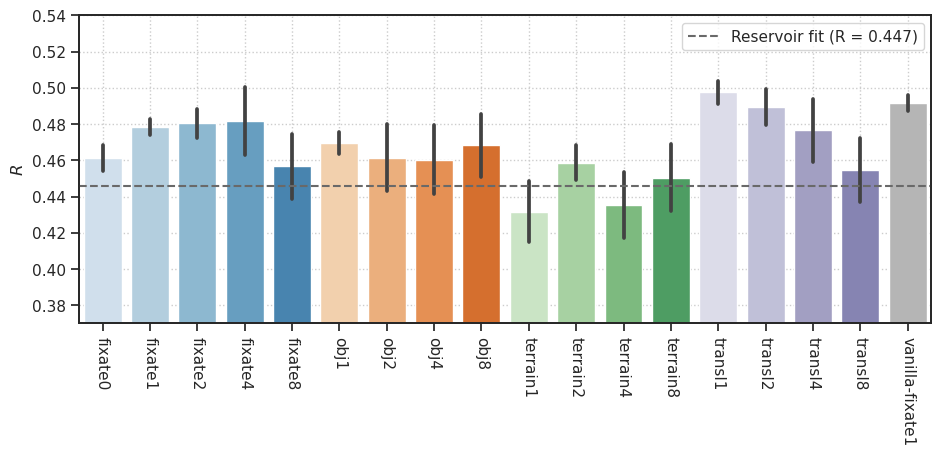

In [8]:
# HIDE CODE


fig, ax = create_figure(1, 1, (11, 4))
sns.barplot(
    data=df,
    x='category',
    y='perf',
    hue='category',
    order=pal,
    palette=pal,
    errorbar='se',
    dodge=False,
    ax=ax,
)
ax.get_legend().remove()
ax.set(xlabel='', ylabel=r'$R$', ylim=(0.37, 0.54))
ax.tick_params(axis='x', rotation=-90)
ax.grid()

axtwix = ax.twinx()
res_r = 0.447
axtwix.axhline(res_r, color='dimgrey', ls='--', label=f'Reservoir fit (R = {res_r})')
axtwix.set(yticks=[])
axtwix.legend()

plt.show()

In [9]:
df.loc[df['expt'] == 'clu096']

,category,nf,beta,root,expt,cell,perf,max_perf,log_alpha,best_lag
21,fixate0,280,1.0,YUWEI,clu096,0,0.680111,0.909688,1.0,2
21,fixate0,280,10.0,YUWEI,clu096,0,0.467377,0.909688,-10.0,2
21,fixate0,280,2.0,YUWEI,clu096,0,0.622490,0.909688,4.0,2
21,fixate0,280,5.0,YUWEI,clu096,0,0.662063,0.909688,8.0,2
21,fixate1,420,0.15,YUWEI,clu096,0,0.705947,0.909688,6.0,2
...,...,...,...,...,...,...,...,...,...,...
21,vanilla-fixate1,420,0.1,YUWEI,clu096,0,0.767184,0.909688,-6.0,2
21,vanilla-fixate1,420,0.2,YUWEI,clu096,0,0.744337,0.909688,1.0,2
21,vanilla-fixate1,420,0.7,YUWEI,clu096,0,0.287944,0.909688,-4.0,10
21,vanilla-fixate1,420,0.8,YUWEI,clu096,0,0.481324,0.909688,-8.0,1


## Get df best

In [10]:
df_best = best_fits(df)

inds = df_best['perf_best'].argsort()[::-1]
df_best.iloc[inds[:20]]

,index,category,nf,beta,root,expt,cell,max_perf,log_alpha,best_lag,perf_best,perf_worst,perf_mu,perf_sd,%+,%-
118,118,fixate2,420,5.0,YUWEI,ytu028,8,0.328052,1.0,8,1.060234,0.060838,0.535342,0.230918,98.047950,-88.635729
51,51,vanilla-fixate1,420,0.1,YUWEI,clu221,3,0.900849,-2.0,4,0.931666,0.374496,0.827485,0.073909,12.590124,-54.742865
28,28,obj1,280,0.15,YUWEI,clu116,0,0.835483,16.0,0,0.923867,0.199772,0.788482,0.094840,17.170275,-74.663683
42,42,vanilla-fixate1,420,0.3,YUWEI,clu209,1,0.923722,-2.0,4,0.922681,0.353418,0.854647,0.066308,7.960502,-58.647488
124,124,fixate1,420,0.2,YUWEI,ytu029,4,0.935583,5.0,3,0.919395,0.614474,0.821541,0.067453,11.911006,-25.204668
49,49,vanilla-fixate1,420,0.3,YUWEI,clu221,1,0.924544,-10.0,4,0.902338,0.449532,0.749489,0.084090,20.393728,-40.021569
29,29,transl1,420,0.3,YUWEI,clu120,0,0.967720,5.0,3,0.900389,0.201365,0.794712,0.094358,13.297493,-74.661883
69,69,fixate1,420,ae,YUWEI,clu267,4,0.979806,6.0,4,0.891663,0.311854,0.815437,0.068434,9.347936,-61.756235
23,23,fixate1,420,0.2,YUWEI,clu104,0,0.980831,6.0,4,0.883021,0.030089,0.684433,0.112434,29.014992,-95.603761
50,50,transl1,420,10.0,YUWEI,clu221,2,0.921324,-10.0,4,0.878807,0.482889,0.727393,0.082552,20.815970,-33.613813


In [11]:
inds = df_best['%+'].argsort()[::-1]
df_best.iloc[inds[:10]]

,index,category,nf,beta,root,expt,cell,max_perf,log_alpha,best_lag,perf_best,perf_worst,perf_mu,perf_sd,%+,%-
34,34,fixate1,420,1.0,YUWEI,clu145,0,0.593791,-8.0,1,0.697875,-0.014680,0.265103,0.172770,163.246467,-105.537616
130,130,transl1,420,0.8,YUWEI,ytu029,12,0.324496,12.0,7,0.651826,-0.049515,0.285684,0.161608,128.163336,-117.332222
31,31,obj1,280,5.0,YUWEI,clu131,0,0.843686,1.0,11,0.531313,0.036619,0.247868,0.121491,114.353023,-85.226302
66,66,transl1,420,10.0,YUWEI,clu229,11,0.716168,2.0,3,0.447193,-0.029625,0.217652,0.093460,105.462347,-113.611003
118,118,fixate2,420,5.0,YUWEI,ytu028,8,0.328052,1.0,8,1.060234,0.060838,0.535342,0.230918,98.047950,-88.635729
113,113,vanilla-fixate1,420,5.0,YUWEI,clu295,11,0.891785,0.0,12,0.736610,-0.030002,0.406027,0.159112,81.418864,-107.389137
112,112,fixate2,420,1.0,YUWEI,clu295,10,0.947970,1.0,2,0.557748,0.063001,0.325215,0.090262,71.501263,-80.627760
83,83,terrain1,210,0.15,YUWEI,clu292,12,0.770807,1.0,12,0.470403,0.054141,0.276315,0.082563,70.241789,-80.405996
87,87,fixate1,420,0.5,YUWEI,clu293,3,0.828781,12.0,12,0.459803,0.074797,0.270510,0.068519,69.976418,-72.349693
86,86,transl4,420,0.15,YUWEI,clu293,1,0.887323,-4.0,10,0.510461,0.100736,0.305741,0.080135,66.958474,-67.051818


In [12]:
sorted_data = sorted(zip(
    df_best['perf_best'],
    df_best['perf_mu'],
    df_best['perf_sd'],
), key=lambda x: x[0])
sorted_data = list(map(
    lambda t: np.array(t),
    zip(*sorted_data),
))

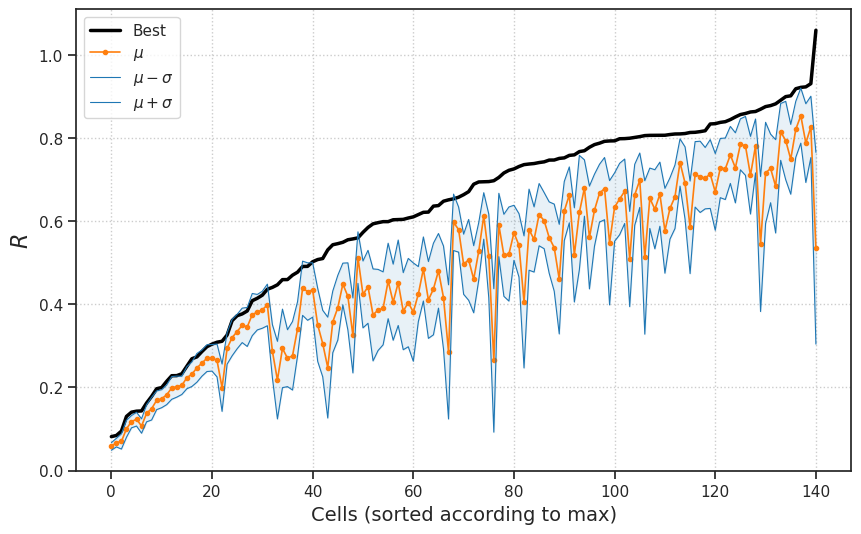

In [13]:
# HIDE CODE


fig, ax = create_figure(1, 1, (10, 6))
ax.plot(sorted_data[0], lw=2.5, color='k', label='Best')
ax.plot(sorted_data[1], lw=1.2, color='C1', marker='.', label=r'$\mu$')

lower = sorted_data[1] - sorted_data[2]
higher = sorted_data[1] + sorted_data[2]
ax.plot(lower, lw=0.8, color='C0', label=r'$\mu - \sigma$')
ax.plot(higher, lw=0.8, color='C0', label=r'$\mu + \sigma$')
ax.fill_between(
    x=range(len(df_best)),
    y1=lower,
    y2=higher,
    color='C0',
    alpha=0.1,
)
ax.set_xlabel('Cells (sorted according to max)', fontsize=14)
ax.set_ylabel(r'$R$', fontsize=16)
ax.locator_params(axis='y', nbins=10)
ax.legend()
ax.grid()
plt.show()

### Pie chart

In [14]:
labels, vals = zip(*collections.Counter(
    df_best['category']).most_common())
vals = [100 * e / sum(vals) for e in vals]

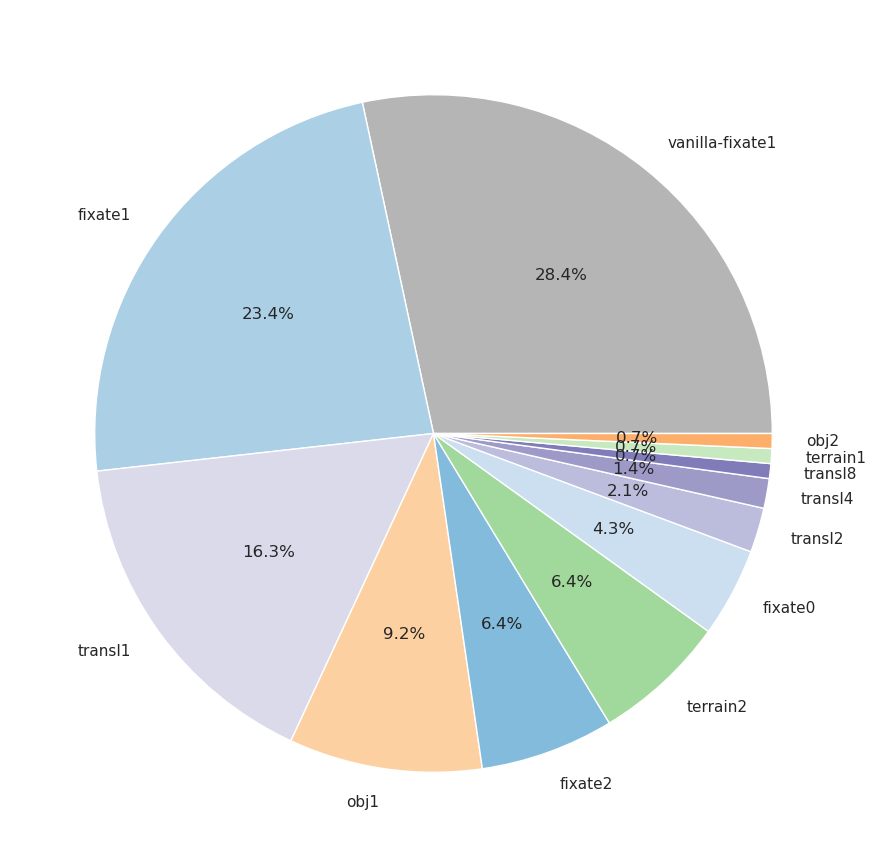

In [15]:
fig, ax = create_figure(1, 1, (13, 11))
ax.pie(
    x=vals,
    labels=labels,
    colors=[pal[e] for e in labels],
    autopct='%0.1f%%',
)
plt.show()

### Summary of results

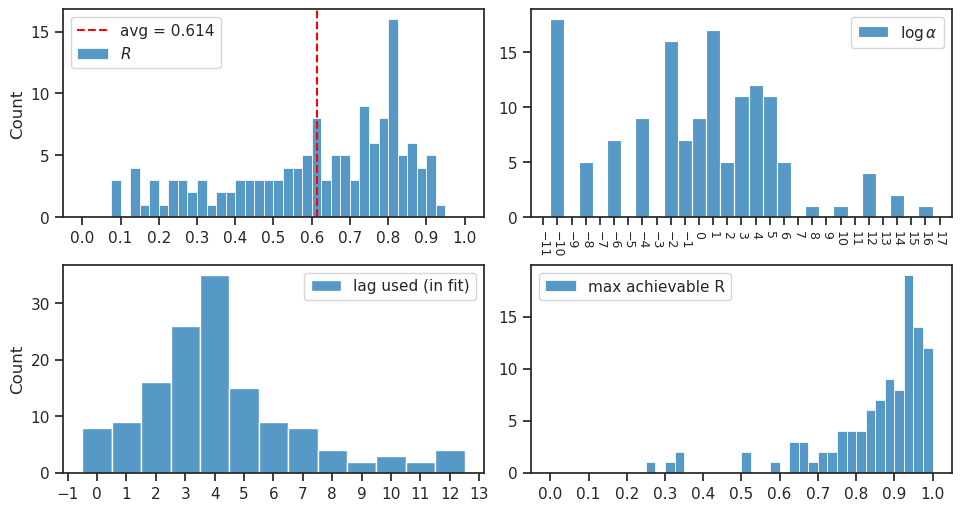

In [16]:
show_neural_results(df_best, 'perf_best');

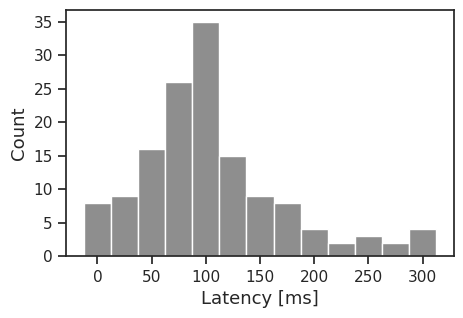

In [19]:
fig, ax = create_figure(1, 1)
sns.histplot(
    df_best['best_lag'].values,
    bins=np.linspace(0, 13, 14) - 0.5,
    color='dimgrey',
    ax=ax,
)
xticks = np.arange(0, 13, 2)
xticklabels = [i * 25 for i in xticks]
ax.set(xticks=xticks, xticklabels=xticklabels)
ax.set_xlabel('Latency [ms]', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
plt.show()

In [20]:
fig.savefig(pjoin(fig_base_dir, 'latency.pdf'), **kws_fig)
fig.savefig(pjoin(fig_base_dir, 'latency.png'), **kws_fig)

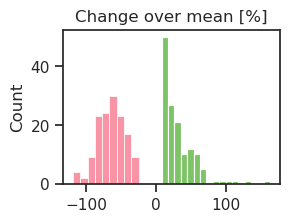

In [16]:
_pal = sns.color_palette('husl')
_pal = {'+': _pal[2], '-': _pal[0]}

fig, ax = create_figure(1, 1, (2.8, 2))
sns.histplot(df_best['%+'], color=_pal['+'], ax=ax)
sns.histplot(df_best['%-'], color=_pal['-'], ax=ax)
ax.set(xlabel='', title='Change over mean [%]')
plt.show()

In [17]:
val = np.concatenate([df_best['%+'].values, df_best['%-'].values])
label = ['+'] * len(df_best['%+']) + ['-'] * len(df_best['%-'])

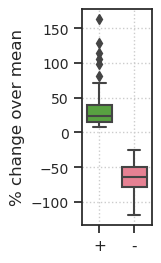

In [18]:
fig, ax = create_figure(1, 1, (0.9, 2.8))

sns.boxplot(
    data=pd.DataFrame({'val': val, 'label': label}),
    y='val',
    x='label',
    palette=_pal,
    width=0.70,
    ax=ax,
)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel='', ylabel='% change over mean')
ax.grid()
plt.show()

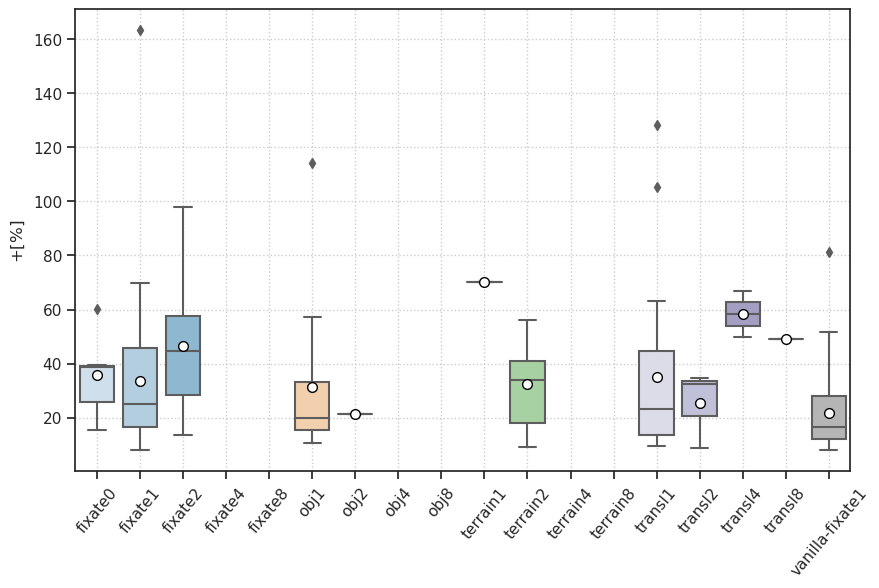

In [19]:
# HIDE CODE


props_mean = {
    'marker': 'o',
    'markerfacecolor': 'white',
    'markeredgecolor': 'k',
    'markersize': 7,
    'alpha': 1.0,
}

fig, ax = create_figure(1, 1, (10, 6))
sns.boxplot(
    data=df_best,
    y='%+',
    x='category',
    hue='category',
    order=pal,
    palette=pal,
    dodge=False,
    showmeans=True,
    meanprops=props_mean,
    ax=ax,
)
ax.set(xlabel='', ylabel=r'$+ [\%]$')
ax.tick_params(axis='x', rotation=50)
ax.get_legend().remove()
ax.grid()
plt.show()

In [20]:
categories = list(df['category'].unique())
df_test = best_fits(df, categories)
perf_best = df_test['perf_best'].mean()
perf_best

0.6141446299847124

In [21]:
reduced_perf = {}
for cat in grouped_by_cat:
    _df = best_fits(df, [e for e in categories if cat not in e])
    reduced_perf[cat] = _df['perf_best'].mean()
print(reduced_perf)

{
    'fixate': 0.5954365459662854,
    'obj': 0.6119716368483556,
    'terrain': 0.6133276496659036,
    'transl': 0.6100695871263933,
    'vanilla-fixate': 0.6095514544882373
}

In [22]:
reduced_perf_objs = {}
for n_obj in grouped_by_nobj:
    _df = best_fits(df, [e for e in categories if int(e[-1]) == n_obj])
    reduced_perf_objs[n_obj] = _df['perf_best'].mean()
print(reduced_perf_objs)

{
    0: 0.5510735572833696,
    1: 0.6083302100928436,
    2: 0.5776207670943184,
    4: 0.5300833150368105,
    8: 0.5137256923996091
}

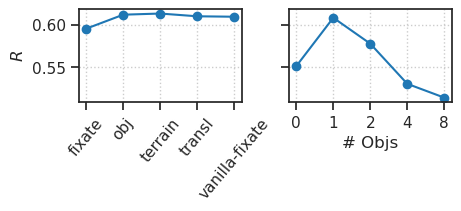

In [23]:
fig, axes = create_figure(1, 2, (4.5, 2), sharey='all', layout='constrained')

axes[0].plot(list(reduced_perf.values()), marker='o')
axes[0].set(xticks=range(len(reduced_perf)), xticklabels=list(reduced_perf), ylabel=r'$R$')
axes[0].tick_params(axis='x', rotation=50)
axes[0].grid()

axes[1].plot(list(reduced_perf_objs.values()), marker='o')
axes[1].set(xticks=range(len(reduced_perf_objs)), xticklabels=list(reduced_perf_objs), xlabel='# Objs')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid()

plt.show()

## Stats

### Paired $t-$test

In [24]:
t = PrettyTable()
t.field_names = [
    'beta',
    'Category #1',
    'Category #2',
    'Statistic',
    'p-val',
    'Significant?',
]

pvals = {}
looper = itertools.combinations(
    list(df['category'].unique()), 2)
betas = sorted([
    b for b in df['beta'].unique()
    if isinstance(b, float)
])
for c1, c2 in looper:
    for beta in betas:
        _df1 = df.loc[
            (df['beta'] == beta) &
            (df['category'] == c1)
        ]
        _df2 = df.loc[
            (df['beta'] == beta) &
            (df['category'] == c2)
        ]
        if len(_df1) != len(_df2) or not len(_df1):
            continue

        test = sp_stats.ttest_rel(
            a=_df1['perf'].values,
            b=_df2['perf'].values,
            alternative='two-sided',
        )
        pvals[(c1, c2)] = test.pvalue
        t.add_row([
            beta,
            c1,
            c2,
            np.round(test.statistic, 2),
            f"{test.pvalue:0.2g}",
            test.pvalue < 0.05,
        ])

In [25]:
print(t)

+------+-----------------+-----------------+-----------+---------+--------------+
| beta |   Category #1   |   Category #2   | Statistic |  p-val  | Significant? |
+------+-----------------+-----------------+-----------+---------+--------------+
| 0.1  |     fixate0     |     fixate1     |    4.35   | 2.7e-05 |     True     |
| 0.5  |     fixate0     |     fixate1     |    -8.0   | 4.1e-13 |     True     |
| 1.0  |     fixate0     |     fixate1     |   -5.71   | 6.5e-08 |     True     |
| 2.0  |     fixate0     |     fixate1     |   -4.37   | 2.4e-05 |     True     |
| 5.0  |     fixate0     |     fixate1     |    -1.8   |  0.074  |    False     |
| 10.0 |     fixate0     |     fixate1     |    3.78   | 0.00023 |     True     |
| 0.5  |     fixate0     |     fixate2     |   -4.04   | 8.6e-05 |     True     |
| 1.0  |     fixate0     |     fixate2     |   -5.83   | 3.6e-08 |     True     |
| 5.0  |     fixate0     |     fixate2     |   -4.36   | 2.5e-05 |     True     |
| 0.1  |     fixate0     |       obj1      |    3.0    |  0.0032 |     True     |
| 0.5  |     fixate0     |       obj1      |   -3.76   | 0.00025 |     True     |
| 0.8  |     fixate0     |       obj1      |    -1.7   |  0.092  |    False     |
| 1.0  |     fixate0     |       obj1      |   -3.68   | 0.00033 |     True     |
| 2.0  |     fixate0     |       obj1      |   -1.74   |  0.084  |    False     |
| 5.0  |     fixate0     |       obj1      |    0.1    |   0.92  |    False     |
| 10.0 |     fixate0     |       obj1      |    5.3    | 4.4e-07 |     True     |
| 0.5  |     fixate0     |     terrain2    |   -3.41   | 0.00084 |     True     |
| 1.0  |     fixate0     |     terrain2    |   -2.85   |  0.005  |     True     |
| 0.5  |     fixate0     |     transl1     |   -8.16   | 1.7e-13 |     True     |
| 0.8  |     fixate0     |     transl1     |   -6.77   | 3.2e-10 |     True     |
| 1.0  |     fixate0     |     transl1     |   -5.75   | 5.3e-08 |     True     |
| 5.0  |     fixate0     |     transl1     |   -1.93   |  0.055  |    False     |
| 10.0 |     fixate0     |     transl1     |    -1.2   |   0.23  |    False     |
| 0.1  |     fixate0     | vanilla-fixate1 |   -1.05   |   0.3   |    False     |
| 0.5  |     fixate0     | vanilla-fixate1 |   -8.73   | 6.9e-15 |     True     |
| 0.8  |     fixate0     | vanilla-fixate1 |   -3.39   | 0.00092 |     True     |
| 1.0  |     fixate0     | vanilla-fixate1 |   -5.61   |  1e-07  |     True     |
| 2.0  |     fixate0     | vanilla-fixate1 |   -4.18   | 5.2e-05 |     True     |
| 5.0  |     fixate0     | vanilla-fixate1 |   -4.55   | 1.1e-05 |     True     |
| 10.0 |     fixate0     | vanilla-fixate1 |    1.77   |  0.079  |    False     |
| 0.5  |     fixate0     |     transl2     |   -5.46   | 2.2e-07 |     True     |
| 1.0  |     fixate0     |     transl2     |   -6.58   | 8.5e-10 |     True     |
| 0.5  |     fixate1     |     fixate2     |    5.51   | 1.6e-07 |     True     |
| 1.0  |     fixate1     |     fixate2     |   -1.06   |   0.29  |    False     |
| 5.0  |     fixate1     |     fixate2     |   -3.53   | 0.00056 |     True     |
| 0.1  |     fixate1     |       obj1      |   -1.53   |   0.13  |    False     |
| 0.15 |     fixate1     |       obj1      |    0.37   |   0.71  |    False     |
| 0.5  |     fixate1     |       obj1      |    3.82   |  0.0002 |     True     |
| 1.0  |     fixate1     |       obj1      |    2.28   |  0.024  |     True     |
| 2.0  |     fixate1     |       obj1      |    2.55   |  0.012  |     True     |
| 5.0  |     fixate1     |       obj1      |    2.26   |  0.026  |     True     |
| 10.0 |     fixate1     |       obj1      |    2.5    |  0.014  |     True     |
| 0.15 |     fixate1     |       obj2      |    3.19   |  0.0017 |     True     |
| 0.15 |     fixate1     |     terrain1    |    4.63   | 8.3e-06 |     True     |
| 0.15 |     fixate1     |     terrain2    |    3.84   | 0.00019 |     True     |
| 0.5  |     fixate1     |     terrain2    |    4.05   | 8.4e-05

In [26]:
print(pvals)

{
    ('fixate0', 'fixate1'): 0.000234617285700705,
    ('fixate0', 'fixate2'): 2.5215538906471712e-05,
    ('fixate0', 'obj1'): 4.3959529688755244e-07,
    ('fixate0', 'terrain2'): 0.004971713558363434,
    ('fixate0', 'transl1'): 0.2338520835815896,
    ('fixate0', 'vanilla-fixate1'): 0.07897847313441819,
    ('fixate0', 'transl2'): 8.538849745972791e-10,
    ('fixate1', 'fixate2'): 0.0005558387125444664,
    ('fixate1', 'obj1'): 0.013669323446315138,
    ('fixate1', 'obj2'): 0.0017322182518939484,
    ('fixate1', 'terrain1'): 8.349286636499581e-06,
    ('fixate1', 'terrain2'): 0.00032382917497155757,
    ('fixate1', 'terrain4'): 3.979655169177608e-06,
    ('fixate1', 'terrain8'): 0.0011876789872436535,
    ('fixate1', 'transl1'): 1.803295423677856e-05,
    ('fixate1', 'transl8'): 0.0002291306254674937,
    ('fixate1', 'vanilla-fixate1'): 0.5083819266573626,
    ('fixate1', 'fixate4'): 0.6994697876750552,
    ('fixate1', 'fixate8'): 0.0007664082271522821,
    ('fixate1', 'obj4'): 0.008117091780135087,
    ('fixate1', 'obj8'): 0.03940420141372756,
    ('fixate1', 'transl2'): 0.0380499742492432,
    ('fixate1', 'transl4'): 0.32491532335646633,
    ('fixate2', 'obj1'): 2.815666068856679e-07,
    ('fixate2', 'terrain2'): 6.951963868735518e-05,
    ('fixate2', 'transl1'): 6.153703782379465e-05,
    ('fixate2', 'vanilla-fixate1'): 0.7094870062175702,
    ('fixate2', 'transl2'): 0.32784468680563295,
    ('obj1', 'obj2'): 0.011415114713365586,
    ('obj1', 'terrain1'): 8.883960494827678e-06,
    ('obj1', 'terrain2'): 0.14943548473062399,
    ('obj1', 'terrain4'): 4.663952108800398e-05,
    ('obj1', 'terrain8'): 0.0011817780047786088,
    ('obj1', 'transl1'): 9.623798563516272e-08,
    ('obj1', 'transl8'): 0.001472787528127591,
    ('obj1', 'vanilla-fixate1'): 0.05812864933128682,
    ('obj1', 'fixate4'): 0.9845453853028514,
    ('obj1', 'fixate8'): 0.0024655090799339313,
    ('obj1', 'obj4'): 0.009762531183501332,
    ('obj1', 'obj8'): 0.0690656360061478,
    ('obj1', 'transl2'): 4.854151504148929e-05,
    ('obj1', 'transl4'): 0.5006804182922376,
    ('obj2', 'terrain1'): 0.016353808340560685,
    ('obj2', 'terrain2'): 0.14069357851411796,
    ('obj2', 'terrain4'): 0.022173699597048558,
    ('obj2', 'terrain8'): 0.24164692434395585,
    ('obj2', 'transl1'): 0.0003736109252987344,
    ('obj2', 'transl8'): 0.32999707941839473,
    ('obj2', 'vanilla-fixate1'): 8.332635514349181e-06,
    ('obj2', 'fixate4'): 0.007097573888311923,
    ('obj2', 'fixate8'): 0.5161403025789157,
    ('obj2', 'obj4'): 0.8854793787106363,
    ('obj2', 'obj8'): 0.40664455656596266,
    ('obj2', 'transl2'): 0.04767690509952488,
    ('obj2', 'transl4'): 0.09788062838479965,
    ('terrain1', 'terrain2'): 0.1318834944293101,
    ('terrain1', 'terrain4'): 0.7488535407684569,
    ('terrain1', 'terrain8'): 0.047725079700438114,
    ('terrain1', 'transl1'): 5.109638574323408e-07,
    ('terrain1', 'transl8'): 0.03852237392292108,
    ('terrain1', 'vanilla-fixate1'): 5.108202498631673e-08,
    ('terrain1', 'fixate4'): 3.224295955740481e-05,
    ('terrain1', 'fixate8'): 0.03557702206650964,
    ('terrain1', 'obj4'): 0.018556348137036556,
    ('terrain1', 'obj8'): 0.000458465855519367,
    ('terrain1', 'transl2'): 2.7878820833197135e-05,
    ('terrain1', 'transl4'): 0.00023641298017932478,
    ('terrain2', 'terrain4'): 0.33495680205614664,
    ('terrain2', 'terrain8'): 0.5877937560848949,
    ('terrain2', 'transl1'): 4.598382915660312e-05,
    ('terrain2', 'transl8'): 0.336985940666788,
    ('terrain2', 'vanilla-fixate1'): 0.0019624532379339628,
    ('terrain2', 'fixate4'): 0.0009590065965172796,
    ('terrain2', 'fixate8'): 0.26369793982144063,
    ('terrain2', 'obj4'): 0.15480690633540184,
    ('terrain2', 'obj8'): 0.01333532093262131,
    ('terrain2', 'transl2'): 6.713786735494482e-07,
    ('terrain2', 'transl4'): 0.0020394770816896048,
    ('terrain4', 'terrain8'): 0.13373546037374734,
    ('terrain4', 'transl1'): 2.8592971680554135e-07,
    ('terrain4', 'transl8'): 0.

### Permutation test

In [28]:
%%time

def statistic(a, b):
    return np.mean(a - b)


t = PrettyTable()
t.field_names = [
    'Category #1',
    'Category #2',
    'Statistic',
    'p-val',
    'Significant?',
]

pvals = {}
looper = itertools.combinations(
    list(df['category'].unique()), 2)
for c1, c2 in looper:
    _data = (
        df.loc[df['category'] == c1, 'perf'].values,
        df.loc[df['category'] == c2, 'perf'].values,
    )
    test = sp_stats.permutation_test(
        data=_data,
        n_resamples=int(1e5),
        permutation_type='samples',
        alternative='two-sided',
        statistic=statistic,
        random_state=0,
    )
    pvals[(c1, c2)] = test.pvalue
    t.add_row([
        c1,
        c2,
        np.round(test.statistic, 2),
        f"{test.pvalue:0.2g}",
        test.pvalue < 0.05,
    ])

CPU times: user 1h 15min 21s, sys: 2min 5s, total: 1h 17min 26s
Wall time: 1h 17min 26s


In [29]:
print(t)

+-------------+-------------+-----------+---------+--------------+
| Category #1 | Category #2 | Statistic |  p-val  | Significant? |
+-------------+-------------+-----------+---------+--------------+
|   fixate0   |   fixate1   |   -0.08   |  2e-05  |     True     |
|   fixate0   |   fixate2   |   -0.05   |  2e-05  |     True     |
|   fixate0   |   fixate4   |   -0.07   |  2e-05  |     True     |
|   fixate0   |   fixate8   |   -0.05   |  2e-05  |     True     |
|   fixate0   |   transl0   |    -0.0   |   0.65  |    False     |
|   fixate0   |   transl1   |   -0.09   |  2e-05  |     True     |
|   fixate0   |   transl2   |   -0.07   |  2e-05  |     True     |
|   fixate0   |   transl4   |   -0.07   |  2e-05  |     True     |
|   fixate0   |   transl8   |   -0.05   |  6e-05  |     True     |
|   fixate0   |     obj1    |   -0.07   |  2e-05  |     True     |
|   fixate0   |     obj2    |   -0.05   |  2e-05  |     True     |
|   fixate0   |     obj4    |   -0.05   |  2e-05  |     True     |
|   fixate0   |     obj8    |   -0.06   |  2e-05  |     True     |
|   fixate0   |   terrain1  |   -0.02   |  0.023  |     True     |
|   fixate0   |   terrain2  |   -0.04   | 0.00046 |     True     |
|   fixate0   |   terrain4  |   -0.03   |  0.0034 |     True     |
|   fixate0   |   terrain8  |   -0.04   |  2e-05  |     True     |
|   fixate1   |   fixate2   |    0.02   |  0.0025 |     True     |
|   fixate1   |   fixate4   |    0.0    |   0.7   |    False     |
|   fixate1   |   fixate8   |    0.03   | 0.00052 |     True     |
|   fixate1   |   transl0   |    0.07   |  2e-05  |     True     |
|   fixate1   |   transl1   |   -0.01   |   0.25  |    False     |
|   fixate1   |   transl2   |    0.01   |   0.55  |    False     |
|   fixate1   |   transl4   |    0.01   |   0.33  |    False     |
|   fixate1   |   transl8   |    0.03   | 0.00016 |     True     |
|   fixate1   |     obj1    |    0.0    |   0.72  |    False     |
|   fixate1   |     obj2    |    0.02   |  0.0019 |     True     |
|   fixate1   |     obj4    |    0.02   |  0.0074 |     True     |
|   fixate1   |     obj8    |    0.02   |   0.04  |     True     |
|   fixate1   |   terrain1  |    0.05   |  2e-05  |     True     |
|   fixate1   |   terrain2  |    0.04   | 0.00016 |     True     |
|   fixate1   |   terrain4  |    0.05   |  2e-05  |     True     |
|   fixate1   |   terrain8  |    0.03   | 0.00086 |     True     |
|   fixate2   |   fixate4   |   -0.02   |  0.012  |     True     |
|   fixate2   |   fixate8   |    0.0    |   0.52  |    False     |
|   fixate2   |   transl0   |    0.05   |  6e-05  |     True     |
|   fixate2   |   transl1   |   -0.03   |  0.0004 |     True     |
|   fixate2   |   transl2   |   -0.02   |  0.015  |     True     |
|   fixate2   |   transl4   |   -0.02   |  0.057  |    False     |
|   fixate2   |   transl8   |    0.01   |   0.41  |    False     |
|   fixate2   |     obj1    |   -0.02   |  0.0086 |     True     |
|   fixate2   |     obj2    |    -0.0   |    1    |    False     |
|   fixate2   |     obj4    |    0.0    |   0.9   |    False     |
|   fixate2   |     obj8    |   -0.01   |   0.37  |    False     |
|   fixate2   |   terrain1  |    0.03   |  0.0072 |     True     |
|   fixate2   |   terrain2  |    0.02   |   0.12  |    False     |
|   fixate2   |   terrain4  |    0.03   |   0.01  |     True     |
|   fixate2   |   terrain8  |    0.01   |   0.26  |    False     |
|   fixate4   |   fixate8   |    0.03   |  0.0021 |     True     |
|   fixate4   |   transl0   |    0.07   |  2e-05  |     True     |
|   fixate4   |   transl1   |   -0.01   |   0.17  |    False     |
|   fixate4   |   transl2   |    0.0    |   0.8   |    False     |
|   fixate4   |   transl4   |    0.01   |   0.58  |    False     |
|   fixate4   |   transl8   |    0.03   | 0.00064 |     True     |
|   fixate4   |     obj1    |    -0.0   |   0.98  |    False     |
|   fixate4   |     obj2    |    0.02   |  0.0073 |     True     |
|   fixate4   |     obj4    |    0.02   |  0.01

In [30]:
print(pvals)

{
    ('fixate0', 'fixate1'): 1.999980000199998e-05,
    ('fixate0', 'fixate2'): 1.999980000199998e-05,
    ('fixate0', 'fixate4'): 1.999980000199998e-05,
    ('fixate0', 'fixate8'): 1.999980000199998e-05,
    ('fixate0', 'transl0'): 0.6464735352646473,
    ('fixate0', 'transl1'): 1.999980000199998e-05,
    ('fixate0', 'transl2'): 1.999980000199998e-05,
    ('fixate0', 'transl4'): 1.999980000199998e-05,
    ('fixate0', 'transl8'): 5.999940000599994e-05,
    ('fixate0', 'obj1'): 1.999980000199998e-05,
    ('fixate0', 'obj2'): 1.999980000199998e-05,
    ('fixate0', 'obj4'): 1.999980000199998e-05,
    ('fixate0', 'obj8'): 1.999980000199998e-05,
    ('fixate0', 'terrain1'): 0.023359766402335978,
    ('fixate0', 'terrain2'): 0.0004599954000459995,
    ('fixate0', 'terrain4'): 0.0034399656003439964,
    ('fixate0', 'terrain8'): 1.999980000199998e-05,
    ('fixate1', 'fixate2'): 0.0025199748002519974,
    ('fixate1', 'fixate4'): 0.7010129898701013,
    ('fixate1', 'fixate8'): 0.0005199948000519994,
    ('fixate1', 'transl0'): 1.999980000199998e-05,
    ('fixate1', 'transl1'): 0.24593754062459375,
    ('fixate1', 'transl2'): 0.5524744752552474,
    ('fixate1', 'transl4'): 0.3323966760332397,
    ('fixate1', 'transl8'): 0.00015999840001599985,
    ('fixate1', 'obj1'): 0.7190728092719073,
    ('fixate1', 'obj2'): 0.001899981000189998,
    ('fixate1', 'obj4'): 0.007439925600743993,
    ('fixate1', 'obj8'): 0.03953960460395396,
    ('fixate1', 'terrain1'): 1.999980000199998e-05,
    ('fixate1', 'terrain2'): 0.00015999840001599985,
    ('fixate1', 'terrain4'): 1.999980000199998e-05,
    ('fixate1', 'terrain8'): 0.0008599914000859991,
    ('fixate2', 'fixate4'): 0.011999880001199987,
    ('fixate2', 'fixate8'): 0.5228547714522854,
    ('fixate2', 'transl0'): 5.999940000599994e-05,
    ('fixate2', 'transl1'): 0.0003999960000399996,
    ('fixate2', 'transl2'): 0.015119848801511985,
    ('fixate2', 'transl4'): 0.057019429805701946,
    ('fixate2', 'transl8'): 0.4146158538414616,
    ('fixate2', 'obj1'): 0.00855991440085599,
    ('fixate2', 'obj2'): 0.995910040899591,
    ('fixate2', 'obj4'): 0.8971510284897151,
    ('fixate2', 'obj8'): 0.37025629743702565,
    ('fixate2', 'terrain1'): 0.007199928000719993,
    ('fixate2', 'terrain2'): 0.12389876101238988,
    ('fixate2', 'terrain4'): 0.01017989820101799,
    ('fixate2', 'terrain8'): 0.25527744722552775,
    ('fixate4', 'fixate8'): 0.0020799792002079978,
    ('fixate4', 'transl0'): 1.999980000199998e-05,
    ('fixate4', 'transl1'): 0.16739832601673985,
    ('fixate4', 'transl2'): 0.8021119788802112,
    ('fixate4', 'transl4'): 0.5805341946580534,
    ('fixate4', 'transl8'): 0.0006399936000639994,
    ('fixate4', 'obj1'): 0.977210227897721,
    ('fixate4', 'obj2'): 0.007319926800731993,
    ('fixate4', 'obj4'): 0.011719882801171989,
    ('fixate4', 'obj8'): 0.0962190378096219,
    ('fixate4', 'terrain1'): 3.999960000399996e-05,
    ('fixate4', 'terrain2'): 0.001119988800111999,
    ('fixate4', 'terrain4'): 1.999980000199998e-05,
    ('fixate4', 'terrain8'): 0.000999990000099999,
    ('fixate8', 'transl0'): 0.00027999720002799973,
    ('fixate8', 'transl1'): 0.0001999980000199998,
    ('fixate8', 'transl2'): 0.0030599694003059967,
    ('fixate8', 'transl4'): 0.018219817801821983,
    ('fixate8', 'transl8'): 0.8311916880831192,
    ('fixate8', 'obj1'): 0.002239977600223998,
    ('fixate8', 'obj2'): 0.5231547684523155,
    ('fixate8', 'obj4'): 0.6285337146628533,
    ('fixate8', 'obj8'): 0.15745842541574584,
    ('fixate8', 'terrain1'): 0.03629963700362997,
    ('fixate8', 'terrain2'): 0.2674573254267457,
    ('fixate8', 'terrain4'): 0.04113958860411396,
    ('fixate8', 'terrain8'): 0.4847151528484715,
    ('transl0', 'transl1'): 1.999980000199998e-05,
    ('transl0', 'transl2'): 1.999980000199998e-05,
    ('transl0', 'transl4'): 1.999980000199998e-05,
    ('transl0', 'transl8'): 5.999940000599994e-05,
    ('transl0', 'obj1'): 1.999980000199998e-05,
    ('transl0', 'obj2'): 7.999920000799993e-05,
 